In [1]:
import pandas as pd
import os
import numpy as np
import re
import gensim.downloader

import sklearn.feature_extraction.text as sk_text
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# READ DATA

We will read the .csv file for all the types of political debates since 1960 to 2020.

In [2]:
pd.options.mode.chained_assignment = None
#path = '/Users/nikhil/data/ML_examples/erdos/'

df = pd.read_csv("aniket-personal/finaldata_party.csv")
df.head()

,Unnamed: 0,speaker,text,type,election_year,date,candidate,result,party
0,0,John Kennedy,I uh – said that Ive served this country for f...,Pres,1960.0,1960-10-21,1.0,1,D
1,1,John Kennedy,"Mr. Howe, Mr. Vice President. First uh – let m...",Pres,1960.0,1960-10-21,1.0,1,D
2,2,Richard Nixon,"Mr. Howe, Senator Kennedy, my fellow Americans...",Pres,1960.0,1960-10-21,1.0,0,R
3,3,John Kennedy,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,1,D
4,4,Richard Nixon,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,0,R


In [86]:
dict_map = {"D":1, "R":0, "Lib":np.nan, "I":np.nan}
df_new = df.replace({"party": dict_map})
df_new.dropna(inplace=True)

# Which word contributes the most in the prediction for each year

In [98]:
df_year = df_new[df_new.election_year == 2020]

X = df_year['text']
y = df_year['party']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("Training & Test Data Overview: ")
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

Training & Test Data Overview: 
X_train:  (4113,)
y_train:  (4113,)
X_test:  (457,)
y_test:  (457,)


In [99]:
def get_numeric_words(df_new):
    all_Text = df_new['text']
    Tfidf = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words='english',ngram_range=(1,1))
    Tfidf.fit_transform(all_Text)
    all_words = Tfidf.get_feature_names_out()
    numeric_words = []
    for w in all_words:
        if not w.isalpha():
            numeric_words.append(w)
    return numeric_words

stop_words = stopwords.words('english')
numeric_words = get_numeric_words(df_new)
custom_stopwords = stop_words + numeric_words

Tfidf = sk_text.TfidfVectorizer(max_features=1000,lowercase=True,analyzer='word',stop_words=custom_stopwords, ngram_range=(1, 1))

In [100]:
clf = Pipeline([("Tfidf vectorizer",Tfidf),("Multinomial NB",MultinomialNB())])
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

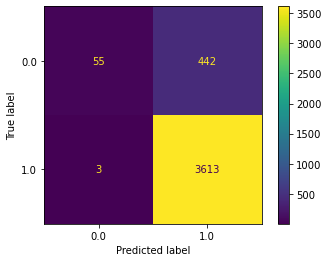

              precision    recall  f1-score   support

         0.0       0.95      0.11      0.20       497
         1.0       0.89      1.00      0.94      3616

    accuracy                           0.89      4113
   macro avg       0.92      0.55      0.57      4113
weighted avg       0.90      0.89      0.85      4113



In [101]:
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
plt.show()
print(classification_report(y_train, clf.predict(X_train)))

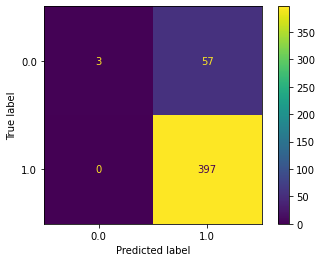

              precision    recall  f1-score   support

         0.0       1.00      0.05      0.10        60
         1.0       0.87      1.00      0.93       397

    accuracy                           0.88       457
   macro avg       0.94      0.53      0.51       457
weighted avg       0.89      0.88      0.82       457



In [102]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()
print(classification_report(y_test, clf.predict(X_test)))

In [103]:
# Words most contributed to predicting 'Democratic'
word_idx = np.argsort(clf['Multinomial NB'].feature_log_prob_[0, :])[::-1]
clf['Tfidf vectorizer'].get_feature_names_out()[word_idx][:10]

array(['know', 'said', 'well', 'joe', 'people', 'excuse', 'would',
       'going', 'oh', 'want'], dtype=object)

In [104]:
# Words most contributed to predicting 'Republican'
word_idx = np.argsort(clf['Multinomial NB'].feature_log_prob_[0, :])[::1]
clf['Tfidf vectorizer'].get_feature_names_out()[word_idx][:10]

array(['zero', 'progress', 'finally', 'progressive', 'promise', 'fellow',
       'fear', 'promises', 'proposal', 'proposed'], dtype=object)

# Can we use model from previous debates for future speech? 

In [76]:
df.election_year.value_counts()

2020.0    4570
2016.0    2325
2012.0    1649
1992.0     513
2008.0     448
2000.0     378
2004.0     301
1996.0     246
1988.0     233
1984.0     166
1976.0     117
1960.0     102
1980.0      67
Name: election_year, dtype: int64

Use data from 1960 - 2016 to predict 2020 debates

In [77]:
df.party.value_counts()

D      6525
R      4340
Lib     128
I       122
Name: party, dtype: int64

In [78]:
df_prev = df_new[df_new.election_year <= 2016]
df_future = df_new[df_new.election_year > 2016]

X_train = df_prev['text']
y_train = df_prev['party']
X_test = df_future['text']
y_test = df_future['party']

print("Training & Test Data Overview: ")
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

Training & Test Data Overview: 
X_train:  (6295,)
y_train:  (6295,)
X_test:  (4570,)
y_test:  (4570,)


In [79]:
def get_numeric_words(df_new):
    all_Text = df_new['text']
    Tfidf = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words='english',ngram_range=(1,1))
    Tfidf.fit_transform(all_Text)
    all_words = Tfidf.get_feature_names_out()
    numeric_words = []
    for w in all_words:
        if not w.isalpha():
            numeric_words.append(w)
    return numeric_words

stop_words = stopwords.words('english')
numeric_words = get_numeric_words(df_new)
custom_stopwords = stop_words + numeric_words

Tfidf = sk_text.TfidfVectorizer(max_features=1000,lowercase=True,analyzer='word',stop_words=custom_stopwords, ngram_range=(1, 1))

In [54]:
clf = Pipeline([("Tfidf vectorizer",Tfidf),("Multinomial NB",MultinomialNB())])
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

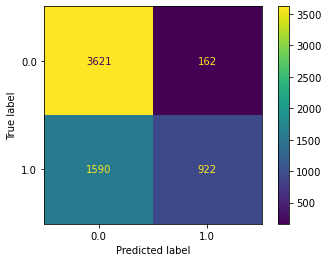

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.81      3783
         1.0       0.85      0.37      0.51      2512

    accuracy                           0.72      6295
   macro avg       0.77      0.66      0.66      6295
weighted avg       0.76      0.72      0.69      6295



In [55]:
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
plt.show()
print(classification_report(y_train, clf.predict(X_train)))

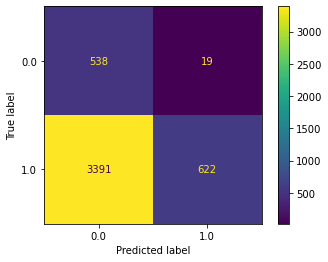

              precision    recall  f1-score   support

         0.0       0.14      0.97      0.24       557
         1.0       0.97      0.15      0.27      4013

    accuracy                           0.25      4570
   macro avg       0.55      0.56      0.25      4570
weighted avg       0.87      0.25      0.26      4570



In [56]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()
print(classification_report(y_test, clf.predict(X_test)))

# --------------------------------------------------------

Lets define the column transformer class. The column traansformer will have parameters like min_date, max_date and type. You can specify the values of the dates for wich you wish to selectt the data. You can further specify the type of debate you wish to select (Presedintial, Vice Presidential, Democratic, Republican). If you want to use all the data for all dates and types, you caan specify 'None' for these parameters. We are only going to consider the debates for Democratic and Republican parties and ignore other parties. The column transformer will output a target varibale caalled 'party' which will be 0 for Republican and 1 for Democratic.

In [3]:
class Custom_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_date, max_date, debate_type):
        '''
        Inputs: 
            min_date: Select the start date, format: "YYYY-MM-DD",(if None selects all dates)
            max_date: Select the end date, format: "YYYY-MM-DD",(if None selects all dates)
            type: List of debate types, e.g ['VP','Pres','Dem','Rep'],(if None all types will be considered)
        
        Output:
            Debate Date, Debate Type selected data frame which contains only the 'Democratic' and 'Republican' party debates
            with targets 0 for 'Republican' and 1 for 'Democratic'
        '''
        self.min_date = min_date
        self.max_date = max_date
        self.debate_type = debate_type
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Get data from particular dates
        if self.min_date!=None and self.max_date!=None:
            X['date'] = pd.to_datetime(X['date'])
            date_mask = (X['date'] > self.min_date) & (X['date'] <= self.max_date)
            masked_data = X.loc[date_mask]
        else:
            masked_data = X
        
        #Get data for particular debate types
        if self.debate_type!=None:
            masked1_data = masked_data.loc[masked_data['type'].isin(self.debate_type)]
        else:
            masked1_data = masked_data
        masked2_data = masked1_data.loc[masked_data['party'].isin(['R','D'])]
        masked2_data.loc[masked2_data['party'] == 'R', 'party'] = 0
        masked2_data.loc[masked2_data['party'] == 'D', 'party'] = 1
        masked2_data['party'] = masked2_data['party'].astype(int)
        
        return masked2_data

In [4]:
#Set True for bigrams otherwise set False for unigrams
Transformer = Custom_Transformer(min_date=None, max_date=None, debate_type=None)
df_new = Transformer.fit_transform(df)

In [5]:
df_new.head()

,Unnamed: 0,speaker,text,type,election_year,date,candidate,result,party
0,0,John Kennedy,I uh – said that Ive served this country for f...,Pres,1960.0,1960-10-21,1.0,1,1
1,1,John Kennedy,"Mr. Howe, Mr. Vice President. First uh – let m...",Pres,1960.0,1960-10-21,1.0,1,1
2,2,Richard Nixon,"Mr. Howe, Senator Kennedy, my fellow Americans...",Pres,1960.0,1960-10-21,1.0,0,0
3,3,John Kennedy,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,1,1
4,4,Richard Nixon,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,0,0


# EDA

In [6]:
def get_party_word_cloud(df_new):
    Text_democratic = df_new[df_new['party']==1]['text']
    Text_republican = df_new[df_new['party']==0]['text']
    Tfidf_D = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words='english',ngram_range=(1,1))
    Tfidf_R = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words='english',ngram_range=(1,1))
    Tfidf_R.fit_transform(Text_republican)
    Tfidf_D.fit_transform(Text_democratic)
    words_D = Tfidf_D.get_feature_names_out()
    words_R = Tfidf_R.get_feature_names_out()
    common_words = []
    unique_words_D =[]
    unique_words_R =[]
    for w in words_D:
        if w in words_R:
           common_words.append(w)
        else:
           unique_words_D.append(w)
    for w in words_R:
        if w not in common_words:
           unique_words_R.append(w)
    unique_alpha_words_R = []
    unique_alpha_words_D = []
    unique_alpha_words_C = []
    for w in unique_words_R:
        if w.isalpha():
           unique_alpha_words_R.append(w)
    for w in unique_words_D:
        if w.isalpha():
           unique_alpha_words_D.append(w)
    for w in common_words:
        if w.isalpha():
           unique_alpha_words_C.append(w)
    wc1 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(unique_alpha_words_D))
    wc2 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(unique_alpha_words_R))
    wc3 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(unique_alpha_words_C))
    return wc1,wc2,wc3,unique_alpha_words_D,unique_alpha_words_R,unique_alpha_words_C


wc1_unique,wc2_unique,wc3_unique,unique_words_D,unique_words_R,unique_words_C = get_party_word_cloud(df_new)

In [ ]:
f = plt.figure(figsize=(400,200))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)

ax1.imshow(wc1_unique)
ax1.set_xlabel('Democratic Unique',fontsize=650)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(wc2_unique)
ax2.set_xlabel('Republican Unique',fontsize=650)
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(wc3_unique)
ax3.set_xlabel('Common',fontsize=650)
ax3.set_xticks([])
ax3.set_yticks([])

plt.tight_layout()

# MODELLING

Lets transform the original data frame and name it as df_new. Lets perform some exploratory data analysis. The function get_party_word_cloud runs the tf-idf vectorizer on the debates text for both the parties (Rep & Dem) and generates an output of word lists. These word lists include common words occuring in the debate text of both the parties as well as words that are unique to both the parties.

Lets see word cloud for the unique words that occur in debate text for both the parties as well as the common words that occur in both of them. We have removed all those words that contain numbers.

Asuming that the words used during the debate reflect the party ideology, our aim is to build a classifier so that given a new sentence of words (representing some ideology), we should be able to predict which party will favour it. We will use the Multinomial Naive Bayes classifier. But first lets remove all numeric words from our data set. The function get_numeric_words collects all the numeric words appearing in the text and adds it to the english stop words list of the tf-idf vectorizer.

In [94]:
bigrams = False
if bigrams:
   ngrams = (2,2)
else:
   ngrams = (1,1)

In [95]:
def get_numeric_words(df_new):
    all_Text = df_new['text']
    Tfidf = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words='english',ngram_range=ngrams)
    Tfidf.fit_transform(all_Text)
    all_words = Tfidf.get_feature_names()
    numeric_words = []
    for w in all_words:
        if not w.isalpha():
           numeric_words.append(w)
    return numeric_words

stop_words = stopwords.words('english')
numeric_words = get_numeric_words(df_new)
custom_stopwords = stop_words + numeric_words
print(custom_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The words above are our custom stop words and will be romved from the fit. Now we will define the tf-idf vectorizer (using ngrams = (1,1) for unigrams and ngrams = (2,2) for bigrams)

In [96]:
Tfidf = sk_text.TfidfVectorizer(max_features=1000,lowercase=True,analyzer='word',stop_words=custom_stopwords,ngram_range=ngrams)

We will first separate the data set df_new into test aand train data. Then we will separate the X and y for training and test data set. X is the 'text' column and y is the 'party' column.

In [97]:
df_new_train,df_new_test = train_test_split(df_new.copy(),test_size=0.3, random_state=42)
X = df_new_train['text']
y = df_new_train['party']
X_test = df_new_test['text']
y_test = df_new_test['party']
Tfidf.fit_transform(df_new_train['text'])


<7605x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 178666 stored elements in Compressed Sparse Row format>

Lets generate a pipeline called Paarty_classifier. The pipeline will initially convert the 'text' column from the input data to a sparse matrix of words using the tf-idf vectorizer and feed that sparse matrix to sklearn's Multinomial Naive Bayes estimator. The Pipeline function is very useful when we are dealing with huge NLP data sets which require a lot of preprocessing before feeding it to the model. The Pipeline function can also be used for hyper-parametrer tuning using MyGridSearchCV.

In [98]:
Party_classifier = Pipeline([("Tfidf vectorizer",Tfidf),("Multinomial NB",MultinomialNB())])

Fit the Party_classifier to the train data and make predictions on the test data. We will also maake predictions on train data to get some insighhts on over-fitting/under-fitting.

In [99]:
Party_classifier.fit(X,y)
y_predict = Party_classifier.predict(X_test)
y_predict_train = Party_classifier.predict(X)

Some metrics

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.69      0.35      0.46      1303
         1.0       0.67      0.89      0.77      1957

    accuracy                           0.68      3260
   macro avg       0.68      0.62      0.61      3260
weighted avg       0.68      0.68      0.64      3260



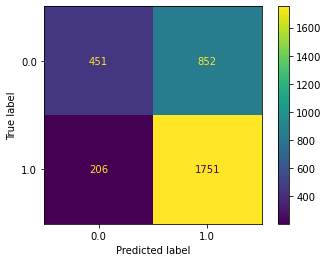

In [100]:
plot_confusion_matrix(Party_classifier, X_test, y_test)
print(classification_report(y_test, y_predict))

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.79      0.42      0.55      3037
         1.0       0.71      0.93      0.80      4568

    accuracy                           0.72      7605
   macro avg       0.75      0.67      0.67      7605
weighted avg       0.74      0.72      0.70      7605



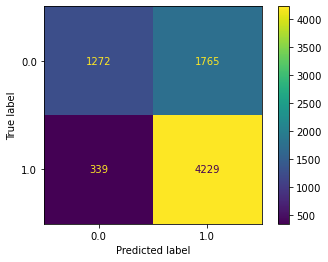

In [101]:
plot_confusion_matrix(Party_classifier, X, y)
print(classification_report(y, y_predict_train))

In [28]:
custom_test = ['muslim','Jew','christian']
y_custom = Party_classifier.predict(custom_test)
y_custom

array([1, 1, 1])

During training, the multinomial naive bayes calculates probabilities such as $Pr(\textrm{'Great'}\ |\ \textrm{Win}),$ the probability that the word "Great" appears in the candidate's speech, given that the candidate has won the election.  Using these probabilities, we can define a **polarity score** for each word $w$,

$$\textrm{polarity}(w) = \log\left(\frac{Pr(w\ |\ \textrm{won})}{Pr(w\ |\ \textrm{lost})}\right).$$

Polarity analysis is an example where a simpler model (naive Bayes) offers more explicability than more complicated models.  Aside from this, naive Bayes models are easy to train, the training process is parallelizable, and these models lend themselves well to online learning.  Given enough training data, naive Bayes models have performed well in NLP applications such as spam filtering.

Speaking in terms of python code, the command  "**party_classifier['Tfidf vectorizer'].get_feature_names_out()**"  will give you a list of filtered words that were used as features in the multinomial naive bayes method. We can get **$\log(Pr(w\ |\ \textrm{won}))$** and **$\log(Pr(w\ |\ \textrm{lost}))$** by using the sklearn's "**model.feature_log_prob**" command as follows,

$\log(Pr(w\ |\ \textrm{won}))$ = classifier['Multinomial NB'].feature_log_prob_[1]

$\log(Pr(w\ |\ \textrm{lost}))$ = classifier['Multinomial NB'].feature_log_prob_[0]

Using this, we can calculate the polarity score for all the words.

Some of the words that the TF-IDF vectorizer uses as features are given below

In [29]:
Voting_classifier = Pipeline([("Tfidf vectorizer",Tfidf),("Multinomial NB",MultinomialNB())])
#Lisa inserted above after error 'Voting_classifyer' not defined.

words = Voting_classifier['Tfidf vectorizer'].get_feature_names()

words[:50]

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['ability',
 'able',
 'abortion',
 'absolutely',
 'access',
 'across',
 'act',
 'action',
 'actually',
 'add',
 'addition',
 'additional',
 'address',
 'administration',
 'afford',
 'affordable',
 'afghanistan',
 'african',
 'agenda',
 'ago',
 'agree',
 'agreement',
 'ahead',
 'aid',
 'air',
 'al',
 'allies',
 'allow',
 'allowed',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'amendment',
 'america',
 'american',
 'americans',
 'americas',
 'among',
 'amount',
 'another',
 'answer',
 'anybody',
 'anyone',
 'anything',
 'applause',
 'approach',
 'area']

In [30]:
def get_polar_words(classifier,top):
    coeff_pos = classifier['Multinomial NB'].feature_log_prob_[1]
    coeff_neg = classifier['Multinomial NB'].feature_log_prob_[0]
    words = classifier['Tfidf vectorizer'].get_feature_names()
    words_join=[]
    for w in words:
        words_join.append(w.replace(" ", "_"))
    words_join = np.array(words_join)
    polarity = coeff_pos-coeff_neg
    polarity_sorted = np.sort(polarity)
    index_sort = np.argsort(polarity)
    words_sorted = words_join[index_sort]
    words_positive = words_sorted[-top:]
    words_negative = words_sorted[:top]
    wc1 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(words_positive))
    wc2 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(words_negative))
    return wc1,wc2,words_join


Lets plot the top 50 most polar words

[]

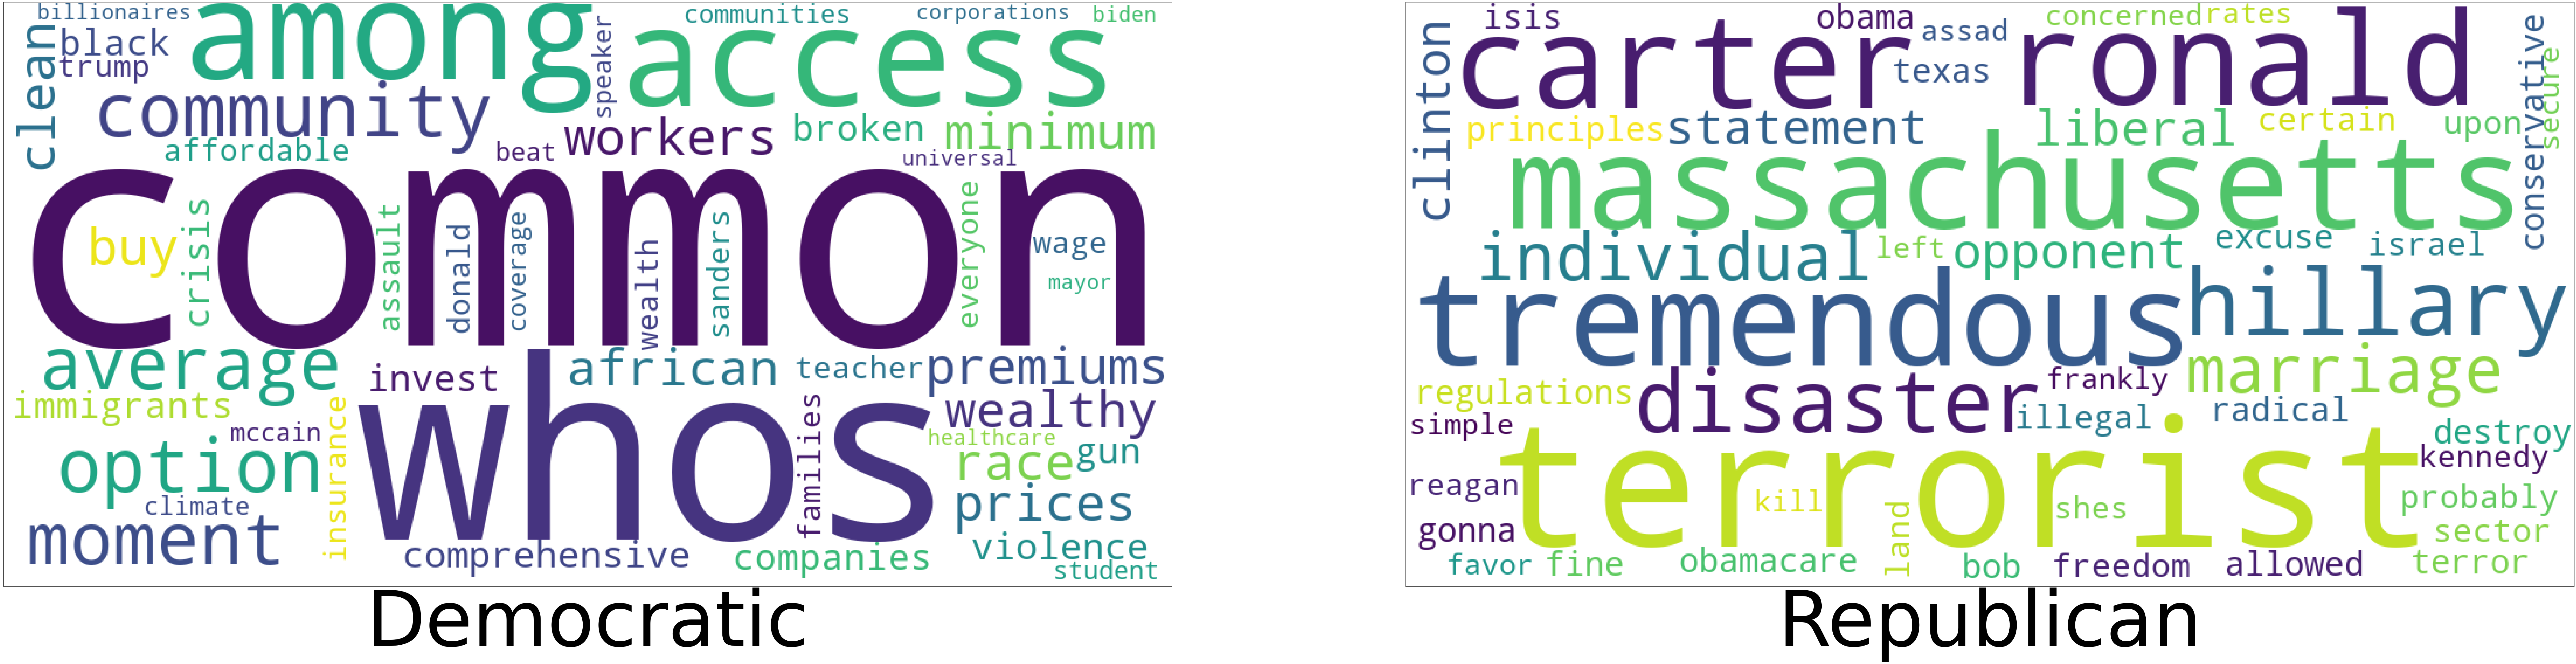

In [31]:
wc1,wc2,feature_names = get_polar_words(Party_classifier,50)

f = plt.figure(figsize=(150,50))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(wc1)
ax1.set_xlabel('Democratic',fontsize=250)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(wc2)
ax2.set_xlabel('Republican',fontsize=250)
ax2.set_xticks([])
ax2.set_yticks([])

